# Load Configuration

In [5]:
import os
import json
import cv2
import numpy as np
from collections import defaultdict
from tqdm import tqdm

from config import PATHS, SPLITS, CLASS_MAP, COCO_CATEGORIES, PARAMETERS
import xml.etree.ElementTree as ET

# Install svgpathtools if not available
try:
    from svgpathtools import parse_path
except ImportError:
    import sys
    import subprocess
    print("Installing svgpathtools...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "svgpathtools"])
    from svgpathtools import parse_path


# Build Bounding Box Annotations

In [6]:
def create_coco_annotations():
    # Get parameters from config
    SAMPLE_STEP = PARAMETERS["sample_step"]
    MAX_VERTS = PARAMETERS["max_verts"]
    
    # Loop through each split
    for split in SPLITS:
        # Skip commented-out splits
        if "#" in split:
            continue
            
        print(f"Processing {split} split...")
        
        # Setup directories
        img_dir = os.path.join(PATHS["images"], split)
        ann_dir = PATHS["annotations"]
        os.makedirs(ann_dir, exist_ok=True)
        
        # Initialize COCO data structure
        coco_data = {
            "images": [],
            "annotations": [],
            "categories": COCO_CATEGORIES
        }
        
        # Initialize IDs
        img_id = 0
        ann_id = 0
        
        # Get all SVG files in directory
        svg_files = []
        for svg_file in os.listdir(img_dir):
            if svg_file.endswith(".svg"):
                svg_files.append(os.path.join(img_dir, svg_file))
        
        # Process each SVG file
        for svg_path in tqdm(svg_files, desc=f"Processing {split}"):
            # Get base filename and corresponding PNG
            base_name = os.path.splitext(os.path.basename(svg_path))[0]
            png_file = f"{base_name}.png"
            png_path = os.path.join(img_dir, png_file)
            
            # Skip if PNG doesn't exist
            if not os.path.exists(png_path):
                continue
                
            # Parse SVG
            tree = ET.parse(svg_path)
            root = tree.getroot()
            
            # Determine namespace
            if "}" in root.tag:
                uri = root.tag[root.tag.find("{")+1:root.tag.find("}")]
                ns = {"svg": uri}
                path_expr = ".//svg:path"
                viewBox = root.get("viewBox")
            else:
                ns = {}
                path_expr = ".//path"
                viewBox = root.get("viewBox")
            
            # Get SVG dimensions
            if viewBox:
                _, _, svg_w, svg_h = map(float, viewBox.split())
            else:
                svg_w = float(root.get("width", 0))
                svg_h = float(root.get("height", 0))
            
            # Get image dimensions and calculate scale factors
            img = cv2.imread(png_path)
            h_px, w_px = img.shape[:2]
            sx, sy = w_px / svg_w, h_px / svg_h
            
            # Add image to COCO data
            coco_data["images"].append({
                "id": img_id,
                "file_name": png_file,
                "width": w_px,
                "height": h_px
            })
            
            # Sample points by (semantic_id, instance_id)
            groups = defaultdict(list)
            
            # Find all path elements
            for elem in root.findall(path_expr, ns):
                # Get IDs
                sid = elem.get("semantic-id")
                iid = elem.get("instance-id")
                
                # Skip invalid paths
                if not sid or not iid:
                    continue
                    
                try:
                    sid = int(sid)
                    iid = int(iid)
                    
                    # Only process known classes
                    if sid not in CLASS_MAP:
                        continue
                        
                    # Get path data
                    d = elem.get("d", "")
                    if not d:
                        continue
                        
                    # Use svgpathtools to parse path
                    try:
                        svg_path = parse_path(d)
                        
                        # Sample points along each segment
                        for seg in svg_path:
                            # Calculate segment length and number of points to sample
                            length = seg.length(error=1e-3)
                            n_pts = max(int(length // SAMPLE_STEP), 1)
                            
                            # Sample points at regular intervals
                            for i in range(n_pts + 1):
                                t = i / n_pts  # Parameter from 0 to 1
                                pt = seg.point(t)  # Complex number (x + yi)
                                
                                # Store scaled point
                                groups[(sid, iid)].append((pt.real * sx, pt.imag * sy))
                    except Exception as e:
                        # Skip paths that can't be parsed
                        continue
                except ValueError:
                    # Skip paths with invalid IDs
                    continue
            
            # Create annotations for each group
            for (sid, iid), points in groups.items():
                # Convert to numpy array
                points_array = np.array(points, dtype=np.float32)
                
                # Need at least 3 points to create a convex hull
                if len(points_array) < 3:
                    continue
                
                # Reshape for OpenCV functions
                points_array = points_array.reshape(-1, 1, 2)
                
                # Calculate convex hull
                hull = cv2.convexHull(points_array)
                
                # Approximate polygon to reduce number of points
                peri = cv2.arcLength(hull, True)
                approx = hull
                
                # Try different epsilon values to get good approximation
                for eps in np.linspace(0.001*peri, 0.1*peri, num=20):
                    c = cv2.approxPolyDP(hull, eps, True)
                    if len(c) <= MAX_VERTS:
                        approx = c
                        break
                
                # Extract coordinates
                coords = approx.reshape(-1, 2)
                
                # Create segmentation
                seg = coords.flatten().tolist()
                
                # Calculate bounding box
                x, y, w_box, h_box = cv2.boundingRect(coords.astype(np.int32))
                
                # Calculate area
                area = float(cv2.contourArea(coords))
                
                # Create annotation
                annotation = {
                    "id": ann_id,
                    "image_id": img_id,
                    "category_id": sid,
                    "segmentation": [seg],
                    "area": area,
                    "bbox": [float(x), float(y), float(w_box), float(h_box)],
                    "iscrowd": 0
                }
                
                # Add to COCO data
                coco_data["annotations"].append(annotation)
                ann_id += 1
            
            # Increment image ID
            img_id += 1
        
        # Save annotations to file
        out_file = os.path.join(ann_dir, f"{split}-annotations.json")
        with open(out_file, 'w') as f:
            json.dump(coco_data, f, indent=2)
        
        print(f"Saved annotations to {out_file}")

# Run the annotation creation process
create_coco_annotations()


Processing train-00 split...


Processing train-00: 100%|██████████| 3760/3760 [01:17<00:00, 48.68it/s]


Saved annotations to data/cad/annotations/train-00-annotations.json
Processing train-01 split...


Processing train-01: 100%|██████████| 6401/6401 [01:33<00:00, 68.66it/s]


Saved annotations to data/cad/annotations/train-01-annotations.json
Processing test-00 split...


Processing test-00: 100%|██████████| 5502/5502 [01:21<00:00, 67.30it/s]


Saved annotations to data/cad/annotations/test-00-annotations.json


## Display a sample

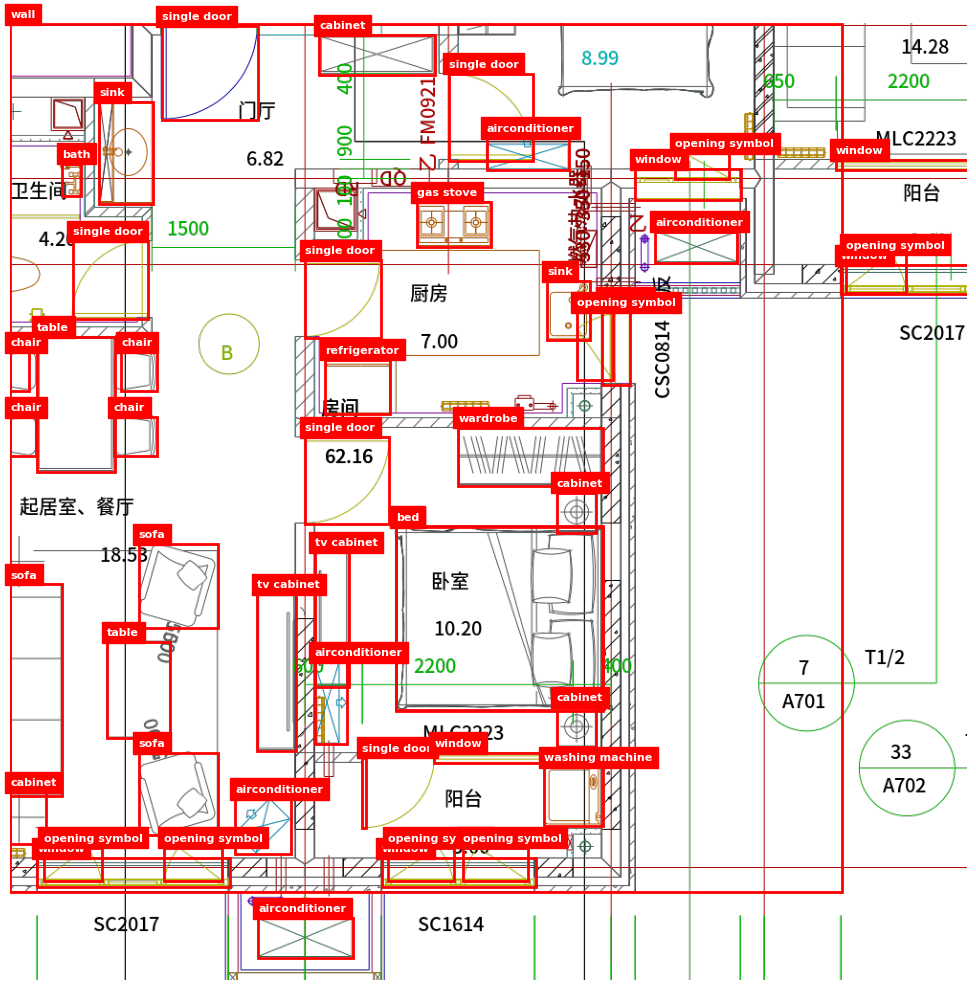

In [7]:
from coco_visualizer import visualize_coco_annotations

visualize_coco_annotations(
    "data/cad/annotations/train-01-annotations.json",
    "0001-0040.png",
    "data/cad/images/train-01")